In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d uciml/sms-spam-collection-dataset

  0% 0.00/211k [00:00<?, ?B/s]
100% 211k/211k [00:00<00:00, 39.4MB/s]


In [10]:
!unzip sms-spam-collection-dataset.zip

Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                


In [11]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [61]:
data = pd.read_csv("spam.csv", encoding="ISO-8859-1")

In [62]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [63]:
data.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [64]:
spam_data = data[["v2", "v1"]]

spam_data.head()

,v2,v1
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [65]:
spam_data.columns = ["sentence", "label"]

spam_data.head()

,sentence,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [66]:
import tensorflow_hub as hub

In [67]:
# using universal sentence encoder

embd = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [68]:
embedding = embd([
                     "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"
])

print(embedding)

tf.Tensor(
[[-0.03133017 -0.06338634 -0.01607501 ... -0.03242778 -0.0457574
   0.05370456]
 [ 0.05080861 -0.01652434  0.01573779 ...  0.00976657  0.03170121
   0.01788118]], shape=(2, 512), dtype=float32)


In [69]:
sentence = list(spam_data["sentence"])

label = list(spam_data["label"])

In [70]:
from sklearn.preprocessing import LabelEncoder

In [71]:
encoder = LabelEncoder()

encoder.fit(label)

LabelEncoder()

In [72]:
encoder.classes_

array(['ham', 'spam'], dtype='<U4')

In [73]:
def encoding(encoder, labels):
  transform = encoder.transform(labels)
  encode = tf.keras.utils.to_categorical(transform)
  return encode

def decoding(encoder, one_hot):
  transform = np.argmax(one_hot, axis = 1)
  decode = encoder.inverse_transform(transform)
  return decode


In [74]:
x = sentence

y = encoding(encoder, label)

In [75]:
len(y)

5572

In [76]:
len(x)

5572

In [77]:
x_train = np.asarray(x[:5000])
y_train = np.asarray(y[:5000])

x_test = np.asarray(x[5000:])
y_test = np.asarray(y[5000:])

In [78]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5000,), (5000, 2), (572,), (572, 2))

In [79]:
import tensorflow as tf
from tensorflow.keras import layers


In [80]:
def embedding_func(x):
  embedding = embd(tf.squeeze(tf.cast(x, tf.string)))
  return embedding

In [ ]:
# building the model

inputs = layers.Input(shape=(1,), dtype = tf.string)
embedding = layers.Lambda(embedding_func, output_shape = (512,))(inputs)
x = layers.Dense(256, activation = "relu")(embedding)
outputs = layers.Dense(2, activation = "softmax")(x)

model = tf.keras.Model(inputs, outputs)


In [82]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 lambda_1 (Lambda)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 131,842
Trainable params: 131,842
Non-trainable params: 0
_________________________________________________________________


In [83]:
# compiling the model

model.compile(loss = tf.keras.losses.categorical_crossentropy,
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])


In [84]:
# fitting data to the model

model.fit(x_train, y_train,
          batch_size = 128,
          epochs = 5,
          )

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/EncoderDNN/EmbeddingLookup/EmbeddingLookupUnique/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/EncoderDNN/EmbeddingLookup/EmbeddingLookupUnique/GatherV2_grad/Reshape:0", shape=(None, 320), dtype=float32), dense_shape=Tensor("gradients/EncoderDNN/EmbeddingLookup/EmbeddingLookupUnique/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


40/40 [==============================] - 5s 31ms/step - loss: 0.3209 - accuracy: 0.8934
Epoch 2/5
40/40 [==============================] - 1s 31ms/step - loss: 0.0843 - accuracy: 0.9786
Epoch 3/5
40/40 [==============================] - 1s 31ms/step - loss: 0.0551 - accuracy: 0.9840
Epoch 4/5
40/40 [==============================] - 1s 31ms/step - loss: 0.0445 - accuracy: 0.9872
Epoch 5/5
40/40 [==============================] - 1s 30ms/step - loss: 0.0381 - accuracy: 0.9890


In [86]:
model_evaluation = model.evaluate(x_test,y_test)

18/18 [==============================] - 1s 28ms/step - loss: 0.0406 - accuracy: 0.9790


In [87]:
print(f"Model Accuracy: {model_evaluation[1] * 100 : 0.2f} %")

Model Accuracy:  97.90 %


In [102]:
pred = model.predict(x_test)

y_pred = decoding(encoder, pred)

In [100]:
y_test_decode = decoding(encoder, y_test)

In [88]:
from sklearn.metrics import confusion_matrix

In [106]:
cm = confusion_matrix(y_test_decode, y_pred)
cm

array([[493,   5],
       [  7,  67]])

In [105]:
import seaborn as sns

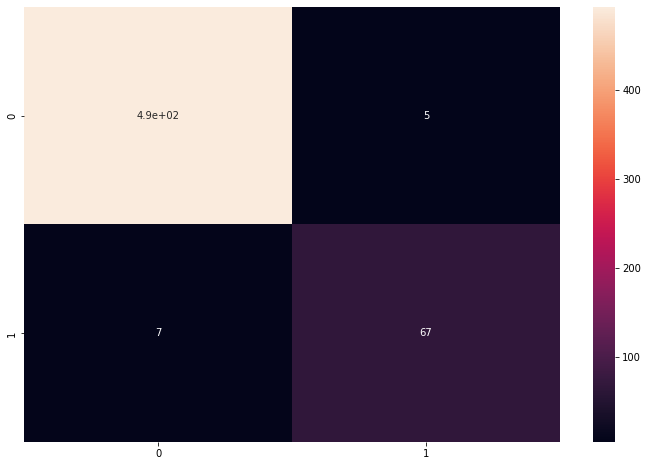

In [110]:
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot = True)
plt.show()